<a href="https://www.kaggle.com/paulwightmore/ai-synth?scriptVersionId=86255657" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Question: What would it take to create an AI based synth.
Answer: I have no idea, but let's give it a shot.

**Part I - Waveform characteristics**

Given a fixed size waveform, can we use AI to categorise the input and to provide a set of outputs representing the waveforms characteristics?

What characteristics?

- Type (sine, sawtooth, square)
- Phase (0.0 0 degs, 1.0 180 degs)
- Attack (0.0 not attack - whatever that means, 1.0 instant on)
- Volume/power
- Decay (0.0 does not decay, 1.0 instant off)
- Harmonics (various standard harmonics e.g. 3rd_harmonic - 0.0 harmonic does not exist, 1.0 harmonic at full intensity)

**Part II - Waveform generation**

Given a set of user controlable characteristics produce a suitable waveform - this could be done, for example, by using sliders for assigning the amount by which a characteristic is present in the output waveform.

**Part III - ???**

???

...some time later...

**Part IV - Fully functional AI generating wavetable synthesizer**

...some more time later...

**Part V - Generate waveform parameters from real instrument samples**

Analyse a sample of a real instrument in order to generate a set of characteristics that allows the sample to be regenerated as closely as the model will allow (given an abundance of additional parameters, temporal capabilities).

What to make your new piano sample more synthetic? No problem just adjust the sine and sawtooth characteristic sliders and watch your new waveform transform in near real time.

Disclaimer: I have no intention of seeing this through, maybe I'll play around to see what I can come up with for part I and part II.
Additional disclaimer: I have no professional nor practical experience of neural nets and I am using the above as an exercise in broadaning my experience.

First things first. Let's provide a wave of generating some waveforms in code. From this we can then generate a series of samples and build up a dataset library...

In [2]:
import math

class context:
    def __init__(self, sample_rate: int):
        self.sample_rate = sample_rate
        
    def __str__(self):
        return f'context(sample_rate: {self.sample_rate})'
    
    #def sample_rate(self):
    #    return self.sample_rate
        
class waveform_generator:
    def __init__(self, context: context):
        self.context = context
    
class sine_wave_generator(waveform_generator):
    def __init__(self, context: context):
        super().__init__(context)
        
    def generate_sample(self, timepoint: float):
        return math.sin(2.0 * math.pi * timepoint)
    

Set up a basic test environment that will allow us to plot our generator classes

In [3]:
def signal_plot(samples: np.array, index):
    df = pd.DataFrame(samples, index)
    df.plot()
    
def waveform_generator_plot(generator: waveform_generator, timespan):
    
    def array_generator(generator, timespan):
        for t in timespan:
            yield generator.generate_sample(t)

    waveform = np.fromiter(array_generator(generator, timespan), float)
    signal_plot(waveform, timespan)

default_step = 0.1;
default_timespan = 1.0;
default_timespan_range = np.arange(0.0, default_timespan + default_step, default_step);

ctx = context(sample_rate=48)

Plot the out put of the sine generator

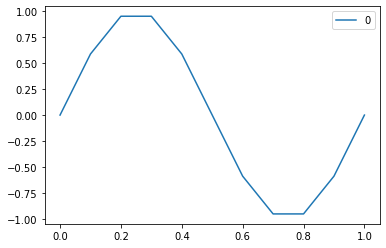

In [4]:
sine_gen = sine_wave_generator(ctx)

waveform_generator_plot(sine_gen, default_timespan_range)

Now let's create a simple square wave generator

In [5]:
class square_wave_generator(waveform_generator):
    def __init__(self, context: context):
        super().__init__(context)
        
    def generate_sample(self, timepoint: float):
        mod = math.fmod(timepoint, 1.0)
        return 1.0 if mod < 0.5 else 0.0 

Plot the out put of the square wave generator

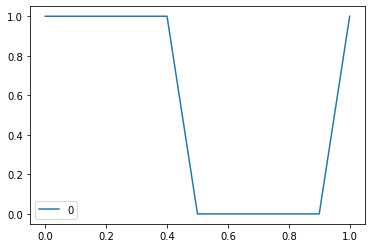

In [6]:
square_gen = square_wave_generator(ctx)

waveform_generator_plot(square_gen, default_timespan_range)

That was pretty straight forward, a sawtooth generator shouldn't be that much more of a stretch.

In [7]:
class sawtooth_wave_generator(waveform_generator):
    def __init__(self, context: context):
        super().__init__(context)
        
    def generate_sample(self, timepoint: float):
        mod2 = math.fmod(timepoint, 1.0)
        return mod2 if mod2 < 0.5 else mod2 - 1.0

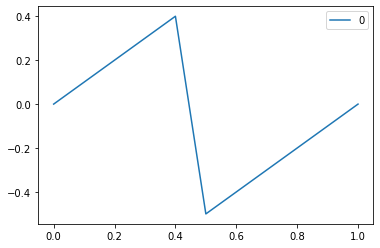

In [8]:
sawtooth_gen = sawtooth_wave_generator(ctx)

waveform_generator_plot(sawtooth_gen, default_timespan_range)

We have some generator classes, now let's create a class for generating a series of samples at a given frequency over a given period of time

In [9]:
class signal_generator:
    def __init__(self, context: context, generator: waveform_generator, frequency: float):
        self.context = context
        self.generator = generator
        self.frequency = frequency
        
    def _generate(self, sample_count: int):
        for t in self._iterate_time(sample_count):
            yield self.generator.generate_sample(t)
            
    def _sample_count(self, timespan: float): 
        return int(timespan * float(self.context.sample_rate + 0.5))
    
    def _iterate_time(self, sample_count: int):
        for s in range(0, sample_count):
            yield (s * self.frequency) / self.context.sample_rate
            
    def iterate_time(self, timespan: float):
        return self._iterate_time(self._sample_count(timespan))
                
    def generate(self, timespan: float):
        return np.fromiter(self._generate(self._sample_count(timespan)), float)
    

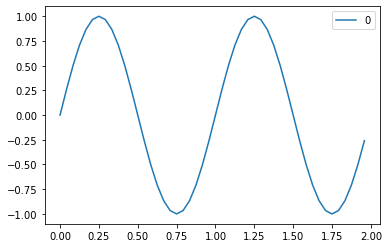

In [10]:
sine_sig_gen_2hz = signal_generator(ctx, sine_gen, 2.0)

waveform = sine_sig_gen_2hz.generate(default_timespan)

time_range = np.fromiter(sine_sig_gen_2hz.iterate_time(default_timespan), float)

signal_plot(waveform, time_range)


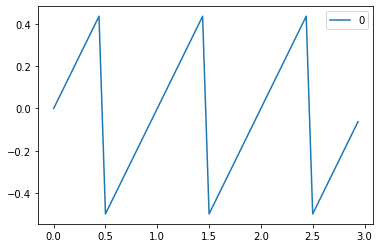

In [11]:
saw_sig_gen_3hz = signal_generator(ctx, sawtooth_gen, 3.0)

waveform = saw_sig_gen_3hz.generate(default_timespan)

time_range = np.fromiter(saw_sig_gen_3hz.iterate_time(default_timespan), float)

signal_plot(waveform, time_range)